# Capstone 3: Yelp's Favorite Hotel Indicators

When users create reviews on Yelp there are multiple factors that go into their ranking. People priortize different factors. Is it clean? What amenities are offered? Is it close to restaurants/shopping, does it have breakfast, does it have a restaurant, how far it is from the airport.

In this project we will sort through the user reviews and use natural language processing to find the highest ranked hotels and what seems to be prioritized in reviews.

## Import and clean the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer


import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
from wordcloud import WordCloud

In [3]:
#Import hotel yelp reviews

reviews = pd.read_csv('tripadvisor_hotel_reviews.csv')
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
#Check for missing values
reviews.isna().sum()

Review    0
Rating    0
dtype: int64

In [5]:
#How are the reviews distributed?
reviews.Rating.value_counts().sort_index()

1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64

We are going to split this into 2 columns to predict. Highly Satisfactory (5) vs Not Satisfactory (1). Leaving our moderate reviews out of the learning model since we want to glean what sets hotels apart most dramatically

Text(0.5, 1.0, 'Distribution of the Star Ratings for Hotels on Yelp')

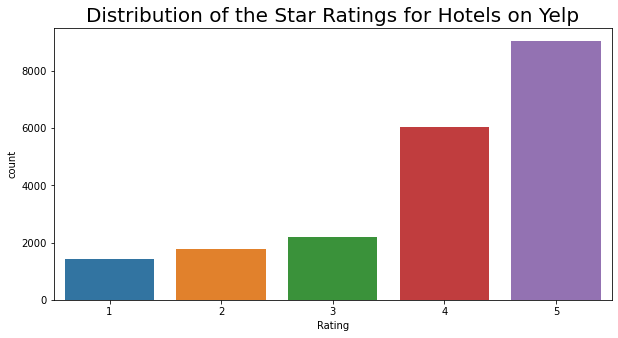

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x='Rating', data = reviews)
plt.title('Distribution of the Star Ratings for Hotels on Yelp', fontsize = 20)

It seems the majority of our reviews are high

In [7]:
#Count how many of each type of reviews we have

excellentReviews = reviews[reviews['Rating']==5]['Rating'].count() + reviews[reviews['Rating']==4]['Rating'].count()
satisfactoryReviews= reviews[reviews['Rating']==3]['Rating'].count()
unsatisfactoryReviews = reviews[reviews['Rating']==2]['Rating'].count() + reviews[reviews['Rating']==1]['Rating'].count()
allReviews = len(reviews)

#Double check assignments were done properly with simple T/F test
excellentReviews + satisfactoryReviews + unsatisfactoryReviews == allReviews

True

In [8]:
print('There are,', excellentReviews, 'four and five star reviews. When put in a ratio the percentage of excellent reviews to all other reviews is', "{0:.0%}".format(excellentReviews/allReviews),'.')

There are, 15093 four and five star reviews. When put in a ratio the percentage of excellent reviews to all other reviews is 74% .


We clearly see the majority of people leaving reviews are satisfied with their stays.

In [9]:
def get_top_n_words(corpus, n=None):
   
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#taken from 
#https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

In [10]:
negative_reviews = reviews[reviews["Rating"]==1]
negative_reviews.head()

,Review,Rating
15,horrible customer service hotel stay february ...,1
32,"noise airconditioner-a standard, arranged stay...",1
40,"bad choice, booked hotel hot wire called immed...",1
65,"hated inn terrible, room-service horrible staf...",1
69,ace grunge lives does mold mildew tiny bed met...,1


In [11]:
positive_reviews = reviews[reviews["Rating"]==5]
positive_reviews.head()

,Review,Rating
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
8,"hotel stayed hotel monaco cruise, rooms genero...",5


In [12]:
#Find the most common words in all reviews

common_words = get_top_n_words(reviews['Review'], 20)
for word, freq in common_words:
    print(word, freq)

hotel 49814
room 35331
not 31709
great 21475
good 17412
staff 16633
stay 15411
did 14006
just 12667
nice 12643
rooms 12401
no 11846
location 11351
stayed 10500
service 10367
night 10151
time 10120
beach 10061
day 9967
breakfast 9737


Right off the bat without machine learning we can't glean a lot of information from these top words. We konw the words hotel/room/stay/location are going to be frequent, but this doesn't give us any workable insight.

In [13]:
#Find the most common words in all negative reviews

common_neg_words = get_top_n_words(negative_reviews['Review'], 20)
for word, freq in common_neg_words:
    print(word, freq)

not 3802
hotel 3666
room 3365
no 1609
did 1319
stay 1233
staff 984
night 923
rooms 923
day 856
service 835
just 793
like 724
told 708
time 706
place 649
desk 642
food 635
resort 633
got 632


In [14]:
#Find the most common positive words in all reviews

common_pos_words = get_top_n_words(positive_reviews['Review'], 20)
for word, freq in common_pos_words:
    print(word, freq)

hotel 22293
room 12509
great 10884
not 9001
staff 7995
stay 6917
good 5875
just 5193
location 4962
stayed 4830
rooms 4801
nice 4491
did 4377
breakfast 4370
service 4300
time 4106
clean 3935
day 3838
excellent 3792
night 3598


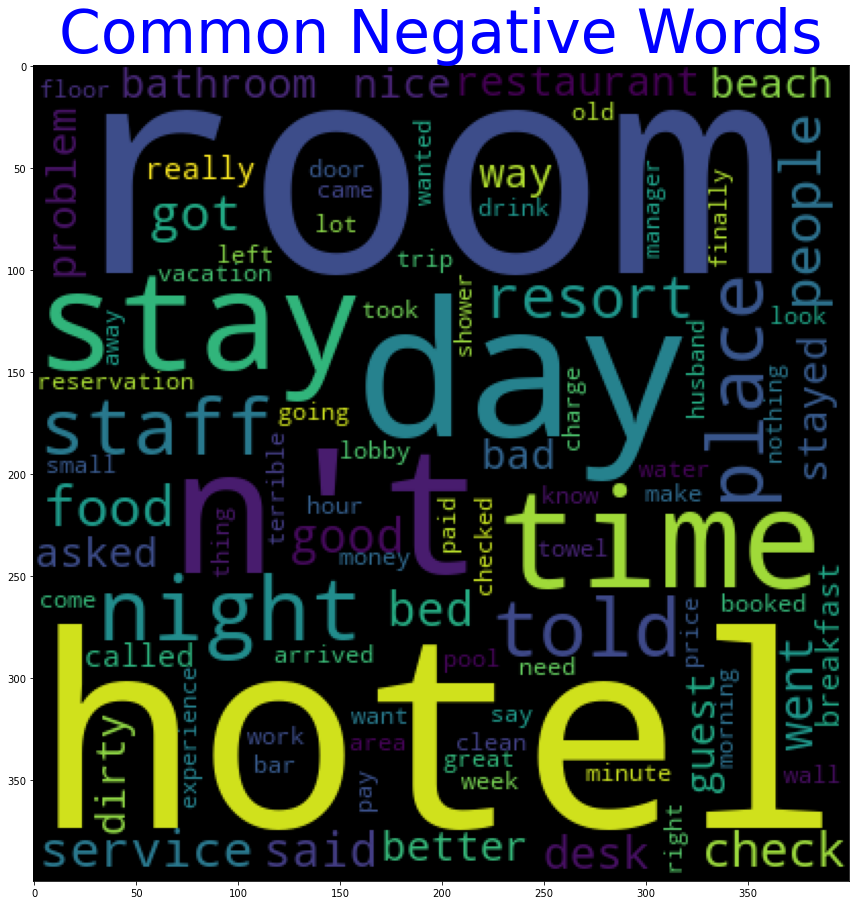

In [15]:
#Create a wordcloud of common negative words
plt.figure(figsize=(15,15))
wc1 = WordCloud(max_words=500, min_font_size=10, 
                height=400,width=400,background_color="black").generate(" ".join(reviews[reviews["Rating"]==1].Review))
plt.title('Common Negative Words', fontsize = 60, color = 'blue')
plt.imshow(wc1)

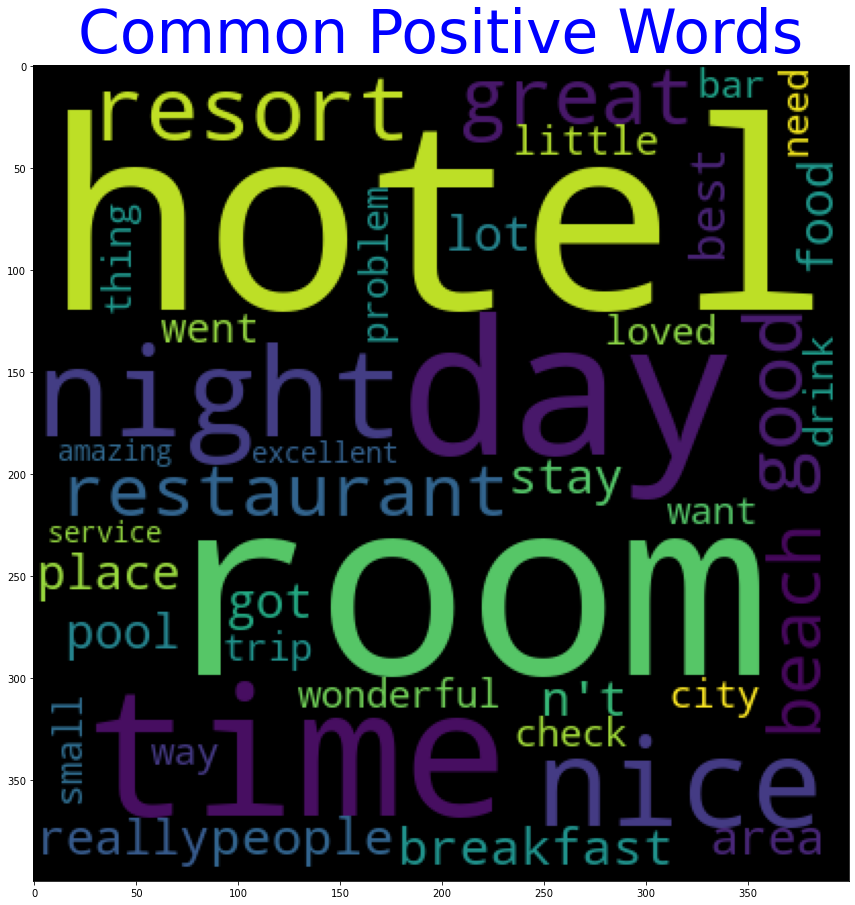

In [16]:
#Create a wordcloud of common positive words

plt.figure(figsize=(15,15))
wc2 = WordCloud(max_words=500, min_font_size=10, 
                height=400,width=400,background_color="black").generate(" ".join(reviews[reviews["Rating"]==5].Review))
plt.title('Common Positive Words', fontsize = 60, color = 'blue')
plt.imshow(wc2)

In [17]:
#Lets find the length of the reviews to examine 
# if there is a pattern of being more/less word for positive/negative reviews

reviews["Length"] = reviews.Review.str.split().apply(len)
reviews.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4* experience hotel monaco seat...,3,217
3,"unique, great stay, wonderful time hotel monac...",5,89
4,"great stay great stay, went seahawk game aweso...",5,191


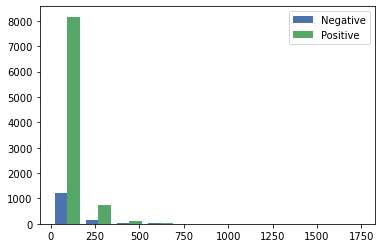

In [18]:
plt.style.use('seaborn-deep')

x = reviews[reviews["Rating"]==1]["Length"]
y = reviews[reviews["Rating"]==5]["Length"]

plt.hist([x, y], label=['Negative', 'Positive'])
plt.legend(loc='upper right')
plt.show()

In [19]:
reviews[reviews["Rating"]==1]["Length"].describe()

count    1421.000000
mean      112.365236
std        99.834855
min        12.000000
25%        51.000000
50%        82.000000
75%       137.000000
max       954.000000
Name: Length, dtype: float64

In [20]:
reviews[reviews["Rating"]==5]["Length"].describe()

count    9054.000000
mean       93.963773
std        90.977999
min         7.000000
25%        44.000000
50%        69.000000
75%       111.000000
max      1755.000000
Name: Length, dtype: float64

When graphed together you can see they both skew towards more words. We had a higher quantity of positive reviews, but it appears the average amount of words is about the same. Positive reviews do have a slightly higher mean of 112 versus negative's 94. 

## Machine Learning

For the purpose of helping management understand the priorites of customers we will just examine the most extreme language. What will get us the most negative (1) reviews and what will get us the most positive (5) reviews.

In [21]:
narrow_df = reviews[(reviews.Rating==5) | (reviews.Rating==1)]

In [22]:
narrow_df.shape

(10475, 3)

In [23]:
#Begin Machine Learning by defining X & y parameters
X = narrow_df['Review']
y = narrow_df['Rating']

In [24]:
#Split testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
# Initialize a CountVectorizer object
count_vectorizer = CountVectorizer(stop_words = 'english')

In [26]:
# Fit and transform with our count vectorizer
X_train_dtm = count_vectorizer.fit_transform(X_train)

In [27]:
# Fit and transform with our count vectorizer
X_test_dtm = count_vectorizer.transform(X_test)

In [28]:
# Create a MultinomialNB model
nb = MultinomialNB()

In [29]:
# Train the Naive Bayes Model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [30]:
# Predict on the test data
y_pred_class = nb.predict(X_test_dtm)

In [31]:
# Examine the accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9782359679266895

In [32]:
#Examine the confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred_class, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    1     5
Actual              
1          318    52
5            5  2244


In [33]:
# Lets examine our a few of our false positives (1-star reviews incorrectly classified as 5-star reviews)
X_test[y_test < y_pred_class].head(10)

5647     disappointed stayed 3 days starting august 13....
17771    not described probably time bare want honest b...
1356     look shabby large hotel absolutely no room ser...
18904    hola not good husband just got married beach r...
11826    big disappointment just come 3 night stay end ...
9019     stay advantage fact hotel 5 mins bus journey a...
9840     terrible hotel 1 2 stars, avoid hotel, not cle...
9805     n't stayed 6 days years ago vowed, problem got...
4860     not stay travel quite frequently london u.s. b...
16296    terrible quality price understood hot market s...
Name: Review, dtype: object

In [34]:
X_test[5647]

"disappointed stayed 3 days starting august 13. hotel wonderful inside good location near las ramblas tour buses, busy street did not hear traffic, arrived early hotel stored luggage, concierge took room, proceeded tip fellow did not small bills change, spouse gave 3 euros promised obtained smaller bills, courcierge left angrily swore blue streak spanish way elevator, probably thought did n't know spanish speak little, spouse did ask concierge money expected, little later gave promised remaninder tip, experience hurtful uncomfortable hotel 3 days, maid service day room not clean, vacuuming not time table/nightstands not wiped, desk fine helpful, breakfast staff disinterested, meal not adequate, selection minimal, meat tasted terrible eggs, lived fruit pastry, staff did not refill coffee unless asked, felt rushing, think complained experiences helps fact makes things worse, complain, overall say hotel great potential management obviously puts little value training supervising hiring app

We can see that the model is reacting to 'hotel wonderful inside,' 'good location,' 'hotel look beautiful.' This person was highly dissapointed with the service, but continued to use glowing descriptors for the hotel itself. Which is easy for a model to confuse.

In [35]:
# Lets examine our a few of our false negatives (5-star reviews incorrectly classified as 1-star reviews)
X_test[y_test > y_pred_class].head(10)

12050    hotel excellent day spa appalling, swissotel w...
434      remarkable service work quickly effortlessly m...
3077     left riu come, engaged planning wed riu palace...
2145     lifesaver hotel lifesaver american airlines in...
14387    perfect hotel best hotels seen traveling lot, ...
Name: Review, dtype: object

In [36]:
X_test[12050]

"hotel excellent day spa appalling, swissotel wonderful place stay sydney, booked hotel directly easy spoke friendly helpful person, arrived early room ready great considering travelling morning, room spotless beautiful bathroom great coffee machine day perfection, nothing hassle hotel, rang asked extra towels delivered promptly smile, breakfast nice included egg chef relaxing, definitely return swissotel sydney, beware amrita day spa, legs waxed day tore skin legs, n't sleep night thought bed, got check discover red swollen stripes legs torn skin, looked disgusting awfully sore painful, went day spa thing morning unhelpful sarcastic spa manager, not willing help really n't care persisted asked prepared, said want money, told, ring boss said yes, practically beg cream, fact damaged skin legs not prepared did not apologise rude aburpt, making official complaint relevant authorities, not use day spa, said not deter staying hotel simple choose day spa,  "

This review was very complementary of the hotel itself, but had many negative words when warning other customers of the day spa. "Rude, abrupt, unhelpful, sarcastic, damaged, complaint, authorities, not"

In [37]:
# Find the vocabulary in the training set
X_train_tokens = count_vectorizer.get_feature_names()
len(X_train_tokens)

31167

In [38]:
# Find the number of times each token appears across each class
one_star_token_count = nb.feature_count_[0, :]
five_star_token_count = nb.feature_count_[1, :]

In [39]:
# create a DataFrame of tokens with their separate one-star and five-star counts

tokens = pd.DataFrame({'token':X_train_tokens, 'one_star':one_star_token_count, 'five_star':five_star_token_count}).set_index('token')

In [40]:
# Add 1 to one-star and five-star to keep division feasible
tokens['one_star'] = tokens.one_star + 1
tokens['five_star'] = tokens.five_star + 1

In [41]:
# First number is one star reviews
nb.class_count_

array([1051., 6805.])

In [42]:
# Convert the star counts into frequencies
tokens['one_star'] = tokens.one_star / nb.class_count_[0]
tokens['five_star'] = tokens.five_star / nb.class_count_[1]

In [43]:
#Calculate the ratio of five start tokens to one store
tokens['five_star_ratio'] = tokens.five_star / tokens.one_star

In [44]:
# Sort the DataFrame by five_star_ratio (descending order) and examine the top 10 words
tokens.sort_values('five_star_ratio', ascending=False).head(10)

,one_star,five_star,five_star_ratio
token,,,
spotless,0.000951,0.041146,43.244673
loved,0.013321,0.225569,16.933820
delightful,0.000951,0.016018,16.834533
brilliant,0.001903,0.031301,16.448420
gem,0.001903,0.031154,16.371198
pricey,0.001903,0.029537,15.521749
eiffel,0.000951,0.014695,15.444526
traditional,0.000951,0.014548,15.290081
wharf,0.000951,0.014254,14.981190


In [45]:
# Sort the DataFrame by five_star_ratio (ascending order), and examine the bottom 10 rows
tokens.sort_values('five_star_ratio', ascending=True).head(10)

,one_star,five_star,five_star_ratio
token,,,
unhelpful,0.041865,0.000441,0.010530
disgrace,0.013321,0.000147,0.011032
unprofessional,0.011418,0.000147,0.012870
rotten,0.011418,0.000147,0.012870
stunk,0.011418,0.000147,0.012870
reeked,0.011418,0.000147,0.012870
disgusting,0.053283,0.000735,0.013790
urine,0.010466,0.000147,0.014040
incompetent,0.010466,0.000147,0.014040


We can see the common words for positive reviews were spotless, loved, delightful, brilliant, gem, pricey, eiffel, traditional, library, and wharf. This leads us to see that while cleanliness is one of the top predictors of if a customer will love their hotel the location is also very important.

We can see the common words for negative reviews were unhelpful, disgrace, reeked, unprofessional, rotten, stunk, disgusting, incompetent, urine, and vomiting. This leads us to see again cleanliness is one of the top predictors if a customer will love thier hotel. The second highest factor in a negative review is staff that is not friendly and accomodating.

# Examine Less Extreme Models

In [46]:
# Define X and y using all the reviews from the original data frame
# So we can examine it's effectiveness with less extreme reviews
X = reviews['Review']
y = reviews['Rating']

In [47]:
# check that y contains 5 different classes
y.value_counts().sort_index()

1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64

In [48]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
# Create document-term matrices using CountVectorizer
X_train_dtm = count_vectorizer.fit_transform(X_train)
X_test_dtm = count_vectorizer.transform(X_test)

In [50]:
# Fit a Multinomial Naive Bayes model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [51]:
# Mke class predictions
y_pred_class = nb.predict(X_test_dtm)

In [52]:
# calculate the accuary
metrics.accuracy_score(y_test, y_pred_class)

0.5770056607456568

In [53]:
# Calculate the null accuracy
y_test.value_counts().head(1) / y_test.shape

5    0.433535
Name: Rating, dtype: float64

In [54]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 141,  142,   18,   49,   14],
       [  28,  132,   51,  173,   47],
       [   6,   43,   36,  373,   83],
       [   0,   18,   10,  773,  765],
       [   1,    7,    1,  338, 1874]])

In [55]:
# Print the classification report
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.80      0.39      0.52       364
           2       0.39      0.31      0.34       431
           3       0.31      0.07      0.11       541
           4       0.45      0.49      0.47      1566
           5       0.67      0.84      0.75      2221

    accuracy                           0.58      5123
   macro avg       0.52      0.42      0.44      5123
weighted avg       0.55      0.58      0.55      5123



The highest precision is for negative 1 star reviews. The highest recall is for 5 star reviews. While the highest f1 score is also for 5 star reviews. 

Meaning 5 star reviews are not are very likely to be identified accurately when they are identified, but with the lower precision we know we are throwing in several reviews which do not belong there (which could be a lot of 4's since they would have similar language). While 1 star reviews have more extreme language so they're likely to be identified correctly, but with the low recall we know we are returning very few results. 

Created using help from the teachings found here: https://github.com/justmarkham/pycon-2016-tutorial